# Load data

In [1]:
import pandas as pd 
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


MC_DATA_FOLDER = '../results/MC_data_1e7'
TOTAL_NUMBER_OF_ANNIHILATIONS = 10_000_000
TOTAL_NUMBER_OF_PHOTONS = TOTAL_NUMBER_OF_ANNIHILATIONS * 2
Rs = [5.0, 10.0,15.0]
scatter_tbls  = {}
lor_tbls = {}

for R in Rs:
    try:
        lor_files = sorted(glob.glob(f"{MC_DATA_FOLDER}/lors_*_R{int(R)}.feather"))
        phot_files = sorted(glob.glob(f"{MC_DATA_FOLDER}/photons_*_R{int(R)}.feather"))

        lors_df = pd.concat((pd.read_feather(f) for f in lor_files), ignore_index=True)
        photons_df = pd.concat((pd.read_feather(f) for f in phot_files), ignore_index=True)
        print(f"R={R}")
        print('Number of LORs:', len(lors_df),"Number of photons", len(photons_df))
        scatter_tbls[R] = photons_df
        lor_tbls[R] = lors_df
    except Exception as e:
        print(f"{e}")


R=5.0
Number of LORs: 9931300 Number of photons 20000000
R=10.0
Number of LORs: 9389901 Number of photons 20000000
R=15.0
Number of LORs: 8324892 Number of photons 20000000


# $d$-distribution

In [2]:
BIN_WIDTH = 0.05 # cm
COLUMNWIDTH_PT = 242.5389
INCH_PER_PT = 1 / 72.27
FIG_W = COLUMNWIDTH_PT * INCH_PER_PT
FIG_H = FIG_W * 2.5

FONTSIZE = 10
TICKLABELSIZE=8
Rs = [5.0, 10.0, 15.0]          # top -> bottom
DMAXS = [3.0, 5.0, 7.0]          # per-panel dmax matching R

BINS = int((DMAXS[-1]) / BIN_WIDTH) + 1

print("Number of bins:", BINS)
print("Bin width:", BIN_WIDTH, " cm")
YLIMS = [(0, 27500), (0, 17000), (0, 10000)]
energy_thresholds = np.array([400,410,420,430,440,450,460,470,480,490,500,510], float)

CMAP = plt.cm.inferno
CMAP_MIN, CMAP_MAX = 0.20, 0.85

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": FONTSIZE,
    "axes.labelsize": TICKLABELSIZE,
    "xtick.labelsize": TICKLABELSIZE,
    "ytick.labelsize": TICKLABELSIZE,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.color": "white",
    "axes.axisbelow": True,
    "grid.alpha": 0.9,
    "grid.linewidth": 1.,
    "axes.facecolor": "whitesmoke",
})

colors = CMAP(np.linspace(CMAP_MIN, CMAP_MAX, len(energy_thresholds)))



Number of bins: 141
Bin width: 0.05  cm


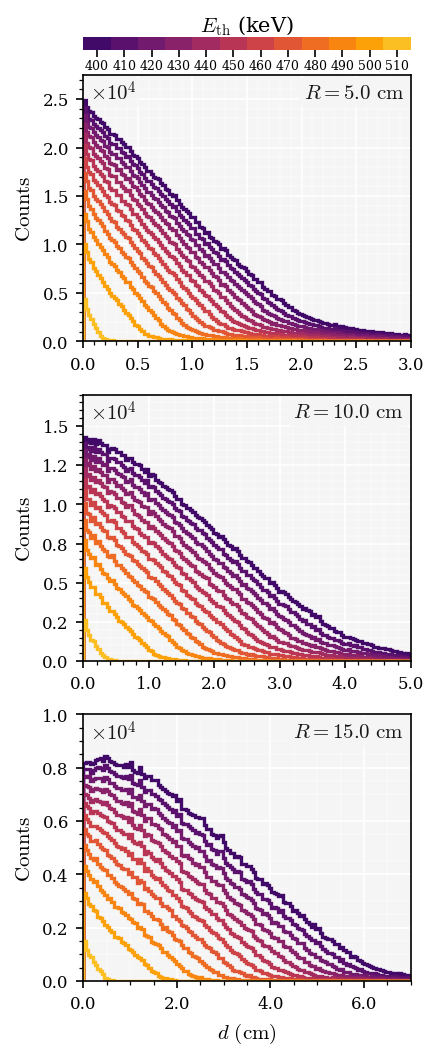

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(FIG_W, FIG_H), sharex=False)
fig.subplots_adjust(
    left=0.15,
    right=0.80,
    top=0.8,      
    bottom=0.08,
    hspace=0.20
)


for i, (R, dmax) in enumerate(zip(Rs, DMAXS)):
    ax = axes[i]
    lor = lor_tbls[R]

    # baseline_mask is the mask for LORs with no scatters on either photon
    baseline_mask = (lor["n_scatter_p1"] == 0) & (lor["n_scatter_p2"] == 0)

    # For each energy threshld
    for Eth, col in zip(energy_thresholds, colors):
        # Collect all accepted LORs 
        m = (lor["exit_energy_1_keV"] >= Eth) & (lor["exit_energy_2_keV"] >= Eth)
        m &= ~baseline_mask

        # Collect all distances associated to these LORs
        d = lor.loc[m, "lor_dist_to_point_cm"].to_numpy(float)
        d = d[np.isfinite(d)]
        d = d[(d >= 0.0)]

        # Plot histogram
        ax.hist(
            d,
            bins=BINS,
            range=(0.0, dmax),
            histtype="step",
            linewidth=1.6,
            color=col,
        )

    # Below formats the following: 
    # - x and y limits
    # - y axis scientific notation
    # - grid
    # - x and y labels
    # - R label
    # - x ticks
    # - x label only on bottom panel
    # - y tick label scaling factor box
    # - minor ticks
    
    ax.set_ylim(*YLIMS[i])
    ax.set_ylabel(r"$\mathrm{Counts}$", fontdict={"size": FONTSIZE})

    sf = mpl.ticker.ScalarFormatter(useMathText=True) # scientific notation for y axis
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(sf)
    fig.canvas.draw()
    oom = ax.yaxis.get_major_formatter().orderOfMagnitude
    ax.yaxis.offsetText.set_visible(False)
    scale = 10.0 ** oom if oom != 0 else 1.0
    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda y, pos, s=scale: f"{(y/s):.1f}") # formats y ticks to 1 decimal place
    )

    ax.text( # puts the scaling factor box on the plot
        0.02, 0.98, rf"$\times 10^{{{oom}}}$",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=FONTSIZE,
        alpha=0.9,
        bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0),
        zorder=10,
    )

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    # x tick labels on all panels, xlabel only bottom
    ax.tick_params(labelbottom=True)
    if i == 2:
        ax.set_xlabel(r"$d~\mathrm{(cm)}$", fontdict={"size": FONTSIZE})

    # R label top-right
    ax.text(
        0.98, 0.97,
        r"$R = " + f"{R:.1f}" + r"~\mathrm{cm}$",
        transform=ax.transAxes,
        va="top", ha="right",
        fontsize=FONTSIZE,
        alpha=0.9,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

    ax.set_xlim(0.0, dmax)
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f')) # formats x ticks to 1 decimal place
# Create colorbar for energy thresholds
N = len(energy_thresholds)
bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)

sm = mpl.cm.ScalarMappable(
    cmap=mpl.colors.ListedColormap(colors),
    norm=norm
)
sm.set_array([])

top_pos = axes[0].get_position()
cbar_h = 0.01
gap = 0.02

cax = fig.add_axes([
    top_pos.x0,
    top_pos.y1 + gap,
     top_pos.width,
    cbar_h
])

cbar = fig.colorbar(
    sm,
    cax=cax,
    orientation="horizontal",
    ticks=np.arange(N) + 0.5,
    drawedges=False,
)

cbar.ax.set_xticklabels([f"{Eth:.0f}" for Eth in energy_thresholds])
cbar.set_label(r"$E_{\mathrm{th}}$ (keV)", fontsize=FONTSIZE, labelpad=2.5)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.ax.tick_params(axis="x", labelsize=6, pad=1)
cbar.outline.set_visible(False)
cbar.ax.tick_params(which='minor', bottom=False, top=False)

plt.show()

fig.savefig(
    "../results/figures/d_distribution/lor_distance_histograms_all_R.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
    transparent=False,
)
fig.savefig(
    "../results/figures/d_distribution/lor_distance_histograms_all_R.svg",
    bbox_inches="tight",
    pad_inches=0.02,
    transparent=False,
)

